# IMDB Sentiment Analysis

Sentiment Aanlysis with a CNN TensorFlow model. Based on:
* [This blog post by WILDML](http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/)
* [This 2014 paper by Kim](https://arxiv.org/pdf/1408.5882v2.pdf).

In [1]:
# Import packages
import os
import re
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from random import shuffle
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from tflearn.data_utils import VocabularyProcessor

# Define directories
train_pos_dir = 'aclImdb/train/pos/'
train_neg_dir = 'aclImdb/train/neg/'
test_pos_dir = 'aclImdb/test/pos/'
test_neg_dir = 'aclImdb/test/neg/'

# Define dataset sizes
data_set_size = 12500

In [2]:
# Read and process data
stop_words = set(stopwords.words("english"))

with open('aclImdb/imdb.vocab', 'r') as myfile:
    vocab = [x for x in myfile.read().split('\n') if not x in stop_words]

def parse_html(data):
    data = BeautifulSoup(data, 'lxml').get_text() # Remove markup
    data = re.sub("[^a-zA-Z]"," ", data) # Remove all non-alphanumeric characters
    data = ' '.join([x for x in data.lower().split() if not x in stop_words]) # Remove stopwords
    return data

train_pos = []
for file_name in os.listdir(train_pos_dir):
    with open(train_pos_dir + file_name, 'r') as myfile:
        train_pos.append(myfile.read())
        
train_neg = []
for file_name in os.listdir(train_neg_dir):
    with open(train_neg_dir + file_name, 'r') as myfile:
        train_neg.append(myfile.read())

test_pos = []
for file_name in os.listdir(test_pos_dir):
    with open(test_pos_dir + file_name, 'r') as myfile:
        test_pos.append(myfile.read())
        
test_neg = []
for file_name in os.listdir(test_neg_dir):
    with open(test_neg_dir + file_name, 'r') as myfile:
        test_neg.append(myfile.read())                 
    
for i in xrange(data_set_size):
    train_pos[i] = parse_html(train_pos[i])
    train_neg[i] = parse_html(train_neg[i])
    test_pos[i] = parse_html(test_pos[i])
    test_neg[i] = parse_html(test_neg[i])    
    
train_x = np.concatenate([train_pos, train_neg])
train_y = np.concatenate([[[0, 1] for _ in xrange(data_set_size)], [[1, 0] for _ in xrange(data_set_size)]])
test_x = np.concatenate([test_pos, test_neg])
test_y = np.concatenate([[[0, 1] for _ in xrange(data_set_size)], [[1, 0] for _ in xrange(data_set_size)]])
    
print '%i train reviews:' % len(train_x)
print train_x[0][:100]
print '\n%i test reviews:' % len(test_x)
print test_x[0][:100]

25000 train reviews:
anime underrated still hardly dorky kids movie noted still come back years first saw one better movi

25000 test reviews:
sure version film saw entertaining know twins gillian chung charlene choi seeing movie think english


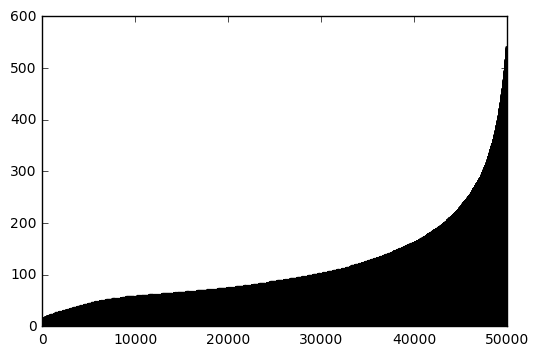

In [3]:
# Graph distribution of review lengths
%matplotlib inline
review_lengths = sorted([len(x.split()) for x in train_x] + [len(x.split()) for x in test_x])[:49900]
plt.show(plt.bar(range(len(review_lengths)), review_lengths))

In [4]:
# Convert reviews into padded word indexes
num_words = 250 # Based on graph (want to capture most reviews without too much padding)
train_x_vector = np.array(list(VocabularyProcessor(num_words).fit_transform(train_x)))
test_x_vector = np.array(list(VocabularyProcessor(num_words).fit_transform(test_x)))

# Shuffle data
shuffled_i = np.random.permutation(np.arange(data_set_size * 2))
train_x_vector = train_x_vector[shuffled_i]
train_y = train_y[shuffled_i]
test_x_vector = test_x_vector[shuffled_i]
test_y = test_y[shuffled_i]

In [11]:
# Variables
num_steps = 11
batch_size = 64
dropout_rate = 0.5
num_classes = 2
vocab_size = len(vocab) # 89380
word_embedding_size = 128 
patch_size = 4
num_channels = 1
conv_depth = 16
full_nodes = 16
conv_stride = [1, 1, 1, 1]
pool_stride = [1, 1, 1, 1]
padding = 'VALID'

# Graph
graph = tf.Graph()
with graph.as_default():
    # Input data
    train_x_tf = tf.placeholder(tf.int32, [batch_size, num_words])
    train_y_tf = tf.placeholder(tf.float32, [batch_size, num_classes])
    test_x_tf = tf.placeholder(tf.int32, [batch_size, num_words])
    
    # Embedded data
    embedding_space = tf.Variable(tf.random_uniform([vocab_size, word_embedding_size])) # 89380 x 128
    train_x_embedded = tf.nn.embedding_lookup(embedding_space, train_x_tf) # None x 250 x 128
    train_x_embedded = tf.expand_dims(train_x_embedded, -1) # None x 250 x 128 x 1
    test_x_embedded = tf.nn.embedding_lookup(embedding_space, test_x_tf)
    test_x_embedded = tf.expand_dims(test_x_embedded, -1)
    
    # Convolutional layer weights and biases
    conv_weights = tf.Variable(tf.truncated_normal([patch_size, word_embedding_size, num_channels, conv_depth]))
    conv_biases = tf.Variable(tf.constant(0.1, shape=(conv_depth,)))
    
    # Fully connected layer weights and biases
    full_weights = tf.Variable(tf.truncated_normal([247 * conv_depth, full_nodes]))
    full_biases = tf.Variable(tf.constant(0.1, shape=(full_nodes,)))
    
    # Output layer weights and biases
    output_weights = tf.Variable(tf.truncated_normal([full_nodes, num_classes]))
    output_biases = tf.Variable(tf.constant(0.1, shape=(num_classes,)))
    
    # Model
    def model(data, drop_out):
        conv = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(data, conv_weights, conv_stride, padding), conv_biases))
        pool = tf.nn.max_pool(conv, pool_stride, pool_stride, padding)
        pool_shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
        full = tf.nn.relu(tf.nn.bias_add(tf.matmul(reshape, full_weights), full_biases))
        if drop_out:            
            full = tf.nn.dropout(full, dropout_rate)
        output = tf.nn.bias_add(tf.matmul(full, output_weights), output_biases)
        return output
    
    # Output
    train_output = model(train_x_embedded, True)
    test_output = model(test_x_embedded, False)
    
    # Optimizer
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(train_output, train_y_tf))
    optimizer = tf.train.AdamOptimizer().minimize(loss)
    
    # Predictions
    train_preds = tf.nn.softmax(train_output)
    test_preds = tf.nn.softmax(test_output)
    
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    
    for i in xrange(num_steps):
        batch_start = batch_size * i % (train_y.shape[0] - batch_size)
        batch_end = batch_start + batch_size
        batch_x = train_x_vector[batch_start:batch_end,:]
        batch_y = train_y[batch_start:batch_end,:]
        feed_dict = {train_x_tf: batch_x, train_y_tf: batch_y}
        _, l, preds = session.run([optimizer, loss, train_preds], feed_dict) 
        
        if i % 10 == 0:
            print l
            
    test_preds_total = np.ndarray(test_y.shape)
    for i in xrange(int(np.floor(test_y.shape[0] / batch_size))):
        batch_start = batch_size * i
        batch_end = batch_start + batch_size
        batch_x = test_x_vector[batch_start:batch_end,:]
        batch_y = test_y[batch_start:batch_end,:]                
        feed_dict = {test_x_tf: batch_x}
        test_preds_total[batch_start:batch_end,:] = session.run(test_preds, feed_dict) 
        
    print test_preds_total[:10]

1564.51
676.177
[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]]
